In [1]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
import pyspark as ps
import pandas as pd
import numpy as np
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )


In [2]:
french_tweets_df = spark.read.json('data/french_tweets.json')
french_tweets_df.printSchema()
french_tweets_df.createOrReplaceTempView('french_tweets')
french_tweets_df.take(10)

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

In [340]:
results = spark.sql('''
select 
    user.id, max(user.friends_count) as friends_count, max(user.followers_count) as followers_count
from 
    french_tweets 
where 
    user.friends_count < 100000 and user.followers_count < 100000
group by 
    user.id
''')

In [341]:
results.show(100)

+------------------+-------------+---------------+
|                id|friends_count|followers_count|
+------------------+-------------+---------------+
|        1252687428|         1128|            941|
|          25679912|          416|           1094|
|         537041978|         1084|           5370|
|        1189045729|          144|            421|
|         596308614|         2376|           1315|
|        3337732251|          108|            303|
|        4748269414|           65|             97|
|         589200985|         1263|            962|
|         565313122|          190|           2338|
|        1263990882|           73|             65|
|        4528611675|          196|            347|
|        2726287065|          140|            212|
|        4054224562|          352|            563|
|         202596834|         1281|           1153|
|        4664328855|           56|              3|
|        1149033228|          646|           1229|
|        2807368175|          2

In [210]:
ids = results.select('friends_count')
ids2 = results.select('followers_count')

print(np.array(ids.take(5)))

<class 'numpy.ndarray'>
[[1128]
 [ 416]
 [1084]
 [ 144]
 [2376]]


In [200]:
a = np.array(ids.collect())
b = np.array(ids2.collect())
a = a.flatten()
b = b.flatten()
print(a.shape)
print(b.shape)


(41228,)
(41228,)


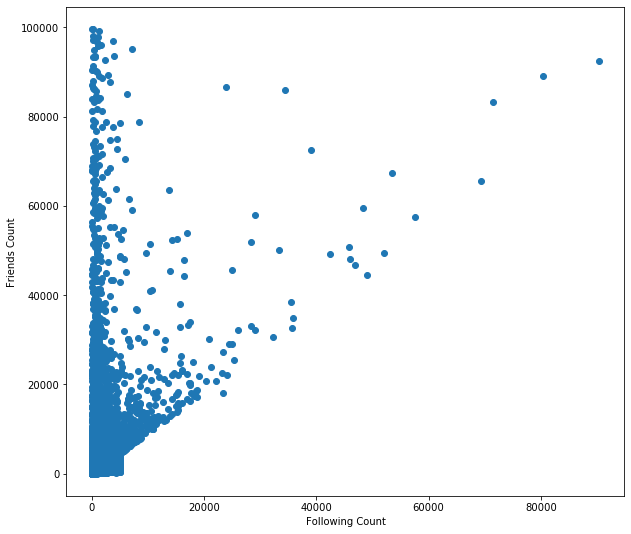

In [201]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Following Count')
ax.set_ylabel('Friends Count')

ax.scatter(a, b)

In [391]:
results = spark.sql('''
select 
    user.name, count(*) as counting, (max(user.friends_count) + max(user.followers_count)) as total_follows
from 
    french_tweets
group by
    user.name
having 
    (max(user.friends_count) + max(user.followers_count)) < 10000
order by counting desc

''')
results.show(10)

+--------------------+--------+-------------+
|                name|counting|total_follows|
+--------------------+--------+-------------+
|   FOCUS Deutschland|    3337|            2|
|  Trendinalia France|     757|         3842|
|      Média Soignant|     695|          327|
|            Fujito🐭|     636|          530|
|           franck jt|     541|         3539|
|            रवि कांत|     429|         4303|
| MACRON serial-crims|     384|          172|
|   SweetSosoFanzouze|     347|         1531|
|Louise Sautron Lebon|     340|         1301|
|       RomainDesbois|     335|         2287|
+--------------------+--------+-------------+
only showing top 10 rows



In [388]:
ids = results.select('counting')
ids2 = results.select('total_follows')
a = np.array(ids.collect())
b = np.array(ids2.collect())
b = b.flatten()
a = a.flatten()
print(a.max())
print(b)


3337
[   2 3842  327 ... 1316  276  689]


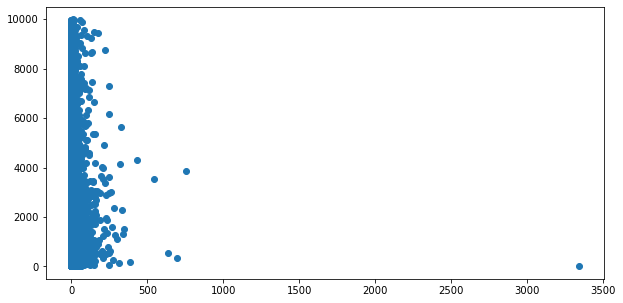

In [389]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(a,b)

In [373]:
results = spark.sql('''
select 
    place.country_code, count(*) as count
from 
    french_tweets
where text is not null
group by 
    place.country_code
''')
results.show(100)

+------------+------+
|country_code| count|
+------------+------+
|        null|   265|
|          GG|    16|
|          GB| 20747|
|          DE|  4510|
|          ES|  1923|
|          FR|179951|
|          CH|  2983|
|          BE|  3519|
|          JE|    41|
|          LU|   971|
+------------+------+



Text(0.5, 0, 'Country Codes')

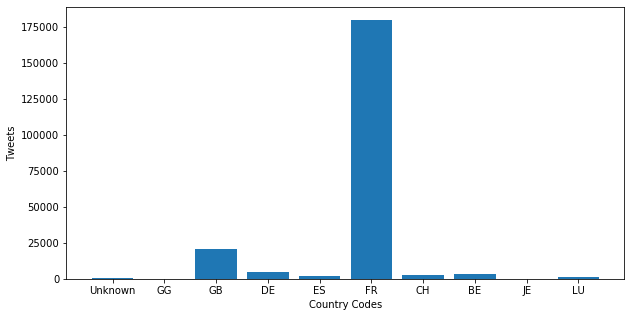

In [374]:
ids = results.select('count')
a = np.array(ids.collect())
a = a.flatten()
x = np.arange(len(a))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
labels = ['Unknown', 'GG','GB','DE','ES','FR','CH','BE','JE','LU']
ax.bar(x,a)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Tweets')
ax.set_xlabel('Country Codes')


In [368]:
results = spark.sql('''
select 
    place.name, count(*)
from 
    french_tweets 
group by 
    place.name
order by count(*) desc
''')
results.show(10)

+-------------+--------+
|         name|count(1)|
+-------------+--------+
|        Paris|   33371|
|   South East|    9481|
|   South West|    5851|
|         Lyon|    4644|
|  Deutschland|    3607|
|     Toulouse|    3393|
|       France|    3317|
|     Bordeaux|    3080|
|Ile-de-France|    2246|
|        Lille|    2163|
+-------------+--------+
only showing top 10 rows



In [401]:
results = spark.sql('''
select 
    user.name, count(text), place.country_code, user.created_at as created
from 
    french_tweets 
group by 
    user.name, place.country_code, user.created_at
order by count(text) desc
''')
results.show(100)
results = results.select('created')
results.take(6)

+--------------------+-----------+------------+--------------------+
|                name|count(text)|country_code|             created|
+--------------------+-----------+------------+--------------------+
|   FOCUS Deutschland|       3337|          DE|Sat Apr 22 20:30:...|
|  Trendinalia France|        757|          FR|Tue Mar 26 20:32:...|
|      Média Soignant|        694|          FR|Thu Feb 25 21:15:...|
|            Fujito🐭|        636|          FR|Thu Jun 26 14:50:...|
|           franck jt|        541|          FR|Thu Dec 15 21:49:...|
|            रवि कांत|        429|          FR|Mon Jun 15 15:24:...|
| MACRON serial-crims|        384|          FR|Fri Jan 13 11:46:...|
|         Sylvie-T 🌹|        347|          FR|Wed Feb 16 16:03:...|
|   SweetSosoFanzouze|        347|          FR|Thu May 17 13:53:...|
|Louise Sautron Lebon|        340|          FR|Sun Feb 13 15:05:...|
|       RomainDesbois|        335|          FR|Tue Nov 02 12:51:...|
|      Akije Hirodi Ω|        324|  

[Row(created='Sat Apr 22 20:30:33 +0000 2017'),
 Row(created='Tue Mar 26 20:32:22 +0000 2013'),
 Row(created='Thu Feb 25 21:15:18 +0000 2010'),
 Row(created='Thu Jun 26 14:50:58 +0000 2014'),
 Row(created='Thu Dec 15 21:49:45 +0000 2016'),
 Row(created='Mon Jun 15 15:24:16 +0000 2009')]

In [451]:
results = spark.sql('''
select 
    user.name, count(*)
from 
    french_tweets 
where 
    text like '%Macron%'
group by 
    user.name
order by count(*) desc
''')
results.show(100)

+--------------------+--------+
|                name|count(1)|
+--------------------+--------+
|Louise Sautron Lebon|     235|
|              Danton|     116|
|  Jeunes avec Macron|      93|
|    Nicolas LECAILLE|      65|
|       RomainDesbois|      54|
|     Etienne Rouault|      51|
|  J-Claude FLAJOULOT|      51|
|        bonnaventure|      47|
| *L'invisible Geôle*|      41|
|  Trendinalia France|      40|
|       Rêv de Presse|      38|
|               T.C-D|      37|
|       LaGaucheMafia|      37|
|           Bets Book|      35|
|       Rachele Zuena|      34|
|     Laura Biancheri|      32|
|      HAVET EMMANUEL|      32|
|       François 🇫🇷|      31|
|              fred28|      28|
|AdelineC FN84 circo4|      28|
|      ᶠᵃᵘᶜʰᵉˡᵉᵛᵉᶰᵗ ∞|      28|
|   Amandine Pasquier|      28|
|Cyrille [No Rotonde]|      27|
|     Stigmabase | FR|      26|
|     Claude Doussiet|      26|
|          Veau Katia|      25|
|        Renaud Camus|      25|
|            CPasbien|      25|
|       An

In [412]:
results = spark.sql('''
select 
    count(*)
from 
    french_tweets 
where 
    text like '%Marcon%' or text like '%Emmanuel%'
''')
results.show(100)

+--------+
|count(1)|
+--------+
|    2598|
+--------+



In [426]:
results = spark.sql('''
select 
    user.name, text
from 
    french_tweets 
where 
    text like '%Marcon%' or text like '%Emmanuel%' or text like '%@EmmanuelMacron%'
''')
results.show(100)

+--------------------+--------------------+
|                name|                text|
+--------------------+--------------------+
|         corinnebord|Parce que la situ...|
|             Chantal|@EmmanuelMacron D...|
|            Mireille|@fredericmorea11 ...|
|            Egora.fr|La mystérieuse vi...|
|      Pierre Gestede|@OriginalDonut @n...|
|    Stéphane Cazalet|@EmmanuelMacron V...|
|               nabil|@jmaphatie @PSG_i...|
|      Pierre Gestede|@OriginalDonut @n...|
|  Sylvain T. Arnaudo|Non mais sérieux ...|
|     Thomas Misrachi|"Imperdable"? @Em...|
|  Mathieu Magnaudeix|Un représentant d...|
|       Sophie Iborra|Vous pensez que #...|
|               salam|@NJENNA1a @Emmanu...|
|      Maissane ZINAI|@misteroms @Emman...|
|   Vanessa Edelweiss|Bon...en considér...|
|   Stanislas HANAUER|.@EmmanuelMacron ...|
|        bonnaventure|@EmmanuelMacron p...|
|Frédéric Desfeuillet|Assez bluffé de l...|
|     Florian AKPABIE|#Presidentielle20...|
|  En Marche Calvados|#President

In [481]:
results = spark.sql('''
select 
    count(*)
from 
    french_tweets 
where 
    text REGEXP 'Macron|Emmanuel|EmmanuelMacron' and 
    text REGEXP 'Corrompu|corrompu|mauvais|corrupt|Corrupt|mal|furieux|haine|Mad|Dumb|Evil|evil|serial|crime|crimes'
''')
results.show(100)

+--------+
|count(1)|
+--------+
|     196|
+--------+



In [485]:
results = spark.sql('''
select 
    count(*)
from 
    french_tweets 
where 
    text REGEXP 'Marine Le Pen|Pen|pen|Marine|marine' 
    and text REGEXP 'Corrompu|corrompu|mauvais|corrupt|Corrupt|mal|furieux|haine|Mad|Dumb|Evil|evil|serial|crime|crimes'
''')
results.show(100)


+--------+
|count(1)|
+--------+
|     275|
+--------+



In [444]:
results = spark.sql('''
select 
    user.name, text
from 
    french_tweets 
where 
    text REGEXP 'Marine Le Pen|Marine|marine|MarineLePen' 
''')
results.show(10)

+--------------------+--------------------+
|                name|                text|
+--------------------+--------------------+
|      Ducret yasmina|Choisir entre le ...|
|  Mathieu Magnaudeix|A #Whirlpool #Ami...|
|                 Man|allez y allez y, ...|
|             Thierry|@Raphael31BA @Tou...|
|            Egora.fr|La conférence des...|
|Nunès Christopher 🎙|Ce deuxième tour ...|
|     jacques.limoges|@MarineElysee @_e...|
|       Café & Lembas|@MateoFrza @Ju_La...|
|      Ducret yasmina|On voit desuite l...|
|      La Gauloise FN|#JamaisMacron mau...|
+--------------------+--------------------+
only showing top 10 rows



In [454]:
results = spark.sql('''
select 
    count(*) as count
from 
    french_tweets 
where 
    text REGEXP 'Marine Le Pen|Marine|marine|MarineLePen|MarineElysee' 
''')
results.show(10)

a = results.select('count')
a = np.array(a.collect())
a = a.flatten()

+-----+
|count|
+-----+
| 1850|
+-----+



In [456]:
results = spark.sql('''
select 
    count(*) as count
from 
    french_tweets 
where 
    text REGEXP 'Macron|Emmanuel|EmmanuelMacron'
    ''')
results.show(100)

b = results.select('count')
b = np.array(b.collect())
b = b.flatten()


+-----+
|count|
+-----+
| 6315|
+-----+

[6315]


[Text(0, 0, 'Marine le Pen'), Text(0, 0, 'Emmanuel Macron')]

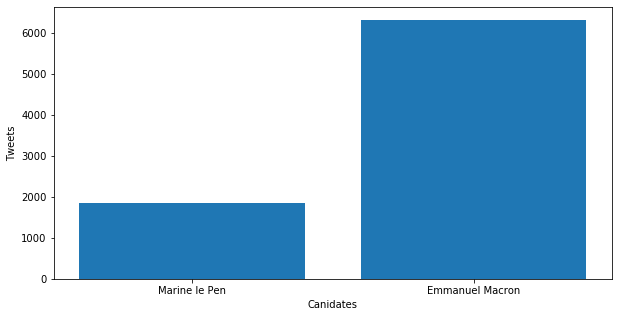

In [463]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
c = np.concatenate((a,b))
ax.bar(np.arange(2),c)
ax.set_xlabel('Canidates')
ax.set_ylabel('Tweets')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Marine le Pen', 'Emmanuel Macron'])


In [471]:
results = spark.sql('''
select 
    count(*) as count
from 
    french_tweets 
where 
    text REGEXP 'Macron|Emmanuel|Emmanuel' and text REGEXP 'Marine Le Pen|Marine|marine|MarineLePen|MarineElysee'
    ''')
results.show(100)

+-----+
|count|
+-----+
|  297|
+-----+



In [472]:
d = results.select('count')
d = np.array(d.collect())
d = d.flatten()

[Text(0, 0, 'Marine le Pen'),
 Text(0, 0, 'Both'),
 Text(0, 0, 'Emmanuel Macron')]

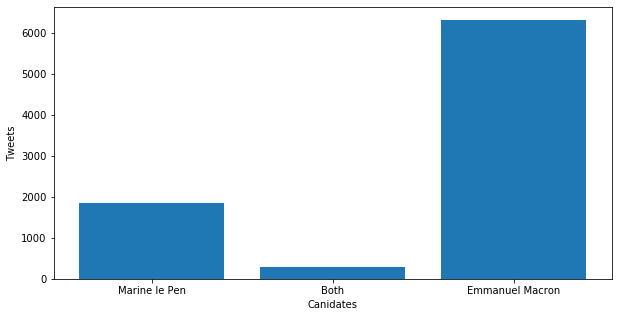

In [474]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
c = np.concatenate((a,d,b))
ax.bar(np.arange(3),c)
ax.set_xlabel('Canidates')
ax.set_ylabel('Tweets')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Marine le Pen', 'Both', 'Emmanuel Macron'])

ModuleNotFoundError: No module named 'descartes'